# Objectives

* Formalize win probability model
* Estimate and predict multinomial logitistic regresison models
* Implement Bayes' rule

## NHL In-Game Win Probability Model

Estimate the following model:
    
$$ p(hw_g| score_{g,t} ) = \frac{p(hg_g| score_{g,t} ) p(hw_g)}{ p(score_{g,t} | hw_g) p(hw_g) +  p(score_{g,t} | \bar{hw_g}) p( \bar{hw_g}) } $$

where,

* $(hw_g| score_{g,t})$: posterior probability of a home team win given the score differential game state
* $p(hw_g$: prior probability of a home team win
* $p(score_{g,t} |hw_g)$ and $p(score_{g,t}  | \bar{hw_g})$: inverse conditional probabilities

In [1]:
# modules
import sys
import os
import pandas
import numpy
import datetime, time

import matplotlib.pyplot as plt
%matplotlib notebook

import statsmodels.api as sm
from pylab import hist, show
import scipy
import statsmodels.api as sm

pandas.set_option("display.max_rows", 35)
pandas.set_option("display.max_columns", 50)
pandas.set_option("display.max_colwidth", 200)



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
dh = pandas.read_csv('2014Events.csv')
dh = dh.drop(['playernumber', 'toirank', 'eventtype', 'zone', 'name', 'advantagetype', 'position'], axis=1)
# smaller development dataframe to decrease execution time
#dh = dh[dh['gamenumber']<=20200]
print (len(dh))
dh.head()

315318


gamedate  season  gamenumber  period  eventtimefromzero  eventnumber  \
0  10/8/2014    2014       20001       1                540           60   
1  10/8/2014    2014       20001       1                 74            9   
2  10/8/2014    2014       20001       2               1127          215   
3  10/8/2014    2014       20001       2                835          189   
4  10/8/2014    2014       20001       1               1142          109   

  teamcode  isthome  tgoals  ogoals vteamcode hteamcode winteamcode  isOTWin  \
0      TOR        1       1       1       MTL       TOR         MTL        0   
1      TOR        1       0       0       MTL       TOR         MTL        0   
2      TOR        1       2       2       MTL       TOR         MTL        0   
3      TOR        1       2       2       MTL       TOR         MTL        0   
4      TOR        1       1       1       MTL       TOR         MTL        0   

   isSOWin  
0        0  
1        0  
2        0  
3        0  
4        0

In [15]:
dh['secStart'] = ((dh['period']-1)*1200 + dh['eventtimefromzero'])
dh = dh.sort_values(by=['season', 'gamenumber', 'secStart'], ascending=[1, 1, 1])
dh['minStart'] = (dh['secStart']/60).astype(int)

In [16]:
# in-game information relative to home team
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh['homeSM'].value_counts()

 0    120943
 1     59306
-1     54637
 2     27469
-2     21743
 3     12387
-3      8195
 4      4851
-4      2936
 5      1592
-5       580
 6       314
-6       288
-7        35
 7        24
-8        18
Name: homeSM, dtype: int64

Obtain game results

In [17]:
df = pandas.DataFrame(dh.groupby(['gamenumber'], axis=0,  as_index=False)['homeSM'].last())
df = df.rename(columns={'homeSM' : 'finalHSM'})
df['finalHSM'].value_counts()

 0    215
 1    196
-1    174
 3    138
 2    125
-2    121
-3     95
 4     50
-4     42
 5     26
-5      8
 6      8
-6      2
-7      2
Name: finalHSM, dtype: int64

Merge game and game-event data

In [84]:
dh = pandas.merge(dh, df, left_on='gamenumber', right_on='gamenumber', how='outer')
dh.head(2)

gamedate  season  gamenumber  period  eventtimefromzero  eventnumber  \
0  10/8/2014    2014       20001       1                  0            1   
1  10/8/2014    2014       20001       1                 19            3   

  teamcode  isthome  tgoals  ogoals vteamcode hteamcode winteamcode  isOTWin  \
0      MTL        0       0       0       MTL       TOR         MTL        0   
1      MTL        0       0       0       MTL       TOR         MTL        0   

   isSOWin  secStart  minStart  homeScore  awayScore  homeSM  homeWin  \
0        0         0         0          0          0       0        0   
1        0        19         0          0          0       0        0   

   finalHSM_x  finalHSM_y  
0          -1          -1  
1          -1          -1

Generage in-game information relative to home team

In [19]:
# can use numpy where command
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh['homeSM'].value_counts()

 0    120943
 1     59306
-1     54637
 2     27469
-2     21743
 3     12387
-3      8195
 4      4851
-4      2936
 5      1592
-5       580
 6       314
-6       288
-7        35
 7        24
-8        18
Name: homeSM, dtype: int64

Create game-minute observations

In [102]:
dm = pandas.DataFrame(dh.groupby(['gamenumber', 'minStart'], axis=0, as_index=False).first())
dm = dm[dm['minStart']!=0]
dm = dm[dm['period']<=3]

Calculate team win percentages by date for game specific priors

In [103]:
dr = pandas.DataFrame()
ds = dh[['gamedate', 'gamenumber', 'hteamcode', 'vteamcode', 'winteamcode', 'isOTWin', 'isSOWin']].groupby(['gamenumber'], as_index=False).first()
teamList = ds['hteamcode'].unique()
teamList

array(['TOR', 'BOS', 'CGY', 'LA', 'BUF', 'PHI', 'PIT', 'WSH', 'DET', 'TB',
       'STL', 'NSH', 'DAL', 'MIN', 'EDM', 'ARI', 'CAR', 'FLA', 'NYI',
       'CBJ', 'CHI', 'COL', 'VAN', 'SJ', 'NYR', 'MTL', 'OTT', 'WPG', 'ANA',
       'NJ'], dtype=object)

For loop to calclulate winning percentage prior to game

In [104]:
for team in teamList:
    du = ds[(ds['hteamcode'] == team) | (ds['vteamcode'] == team)].copy()
    du.loc[::,'team'] = team
    du.loc[::,'wins']   = du.apply(lambda x: 1 if x['winteamcode'] == team else 0, axis=1).shift(1).cumsum()
    du.loc[::,'loss']   = du.apply(lambda x: 1 if x['winteamcode'] != team else 0, axis=1).shift(1).cumsum()
    dr = dr.append(du)
    print ('completed loop for ' + team)
dr.loc[::, 'winPer'] = dr['wins'] /(dr['wins'] + dr['loss'])

completed loop for TOR
completed loop for BOS
completed loop for CGY
completed loop for LA
completed loop for BUF
completed loop for PHI
completed loop for PIT
completed loop for WSH
completed loop for DET
completed loop for TB
completed loop for STL
completed loop for NSH
completed loop for DAL
completed loop for MIN
completed loop for EDM
completed loop for ARI
completed loop for CAR
completed loop for FLA
completed loop for NYI
completed loop for CBJ
completed loop for CHI
completed loop for COL
completed loop for VAN
completed loop for SJ
completed loop for NYR
completed loop for MTL
completed loop for OTT
completed loop for WPG
completed loop for ANA
completed loop for NJ


In [105]:
# merge 
dr = dr[['gamenumber', 'team', 'winPer']]
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'hteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'homeWinPer'})
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'vteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'awayWinPer'})
dm = dm.drop(['team_x', 'team_y'], axis=1)

dm.head(2)
# completed minute-level data'

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer  
0        0          -1          -1         NaN         NaN  
1        0          -1          -1         NaN         NaN

## Score margin summary analysis

In [106]:
ds = pandas.DataFrame()
ds['trDScLaActu'] = dm[dm['homeWin']==1].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
ds['faDScLaActu'] = dm[dm['homeWin']==0].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
ds = ds.dropna(axis=0)
DS = ds.copy(); del ds
DS.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


trDScLaActu  faDScLaActu
1     0.012520    -0.012750
2     0.039124    -0.020183
3     0.057994    -0.031308
4     0.090062    -0.049180
5     0.123245    -0.096715

## Plot mean inverse conditionals

<IPython.core.display.Javascript object>


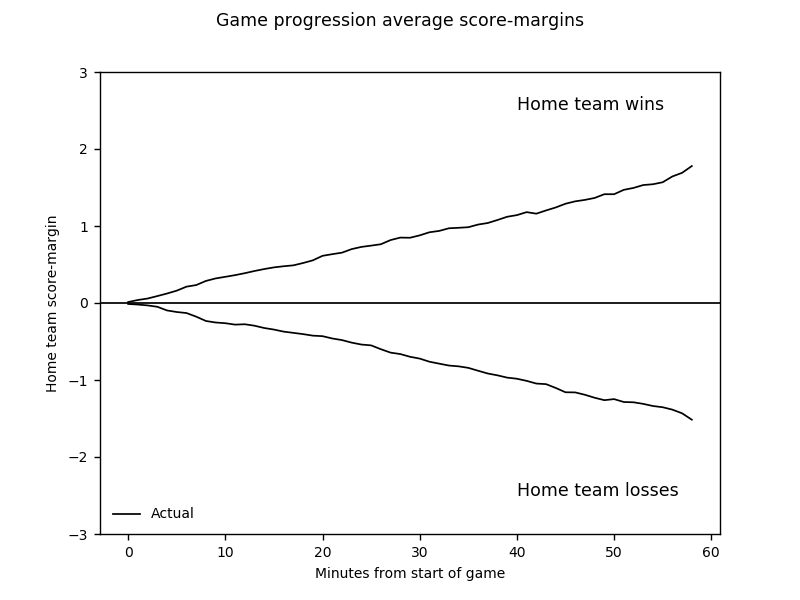

[]

In [107]:
# create index to plot
ds = DS.copy()
ds = ds.reset_index()
ds = ds.rename(columns={'index' : 'minStart'})
ds = ds[ds['minStart']!=0]

# line plot
tempName = 'condLeagueScoreMarginsActu.pdf'
tempFile = os.path.join(tempName)

fig, ax0 = plt.subplots(facecolor='white')
ax0.plot(ds.index, ds['trDScLaActu'], label='Actual'  , marker='', linestyle='-', linewidth=1, color='black')
ax0.plot(ds.index, ds['faDScLaActu'], label='', marker='', linestyle='-', linewidth=1, color='black')
ax0.set_title('', fontsize=8)
ax0.set_xlabel('Minutes from start of game', fontsize=8)
ax0.tick_params(axis='both', labelsize=8)
ax0.set_ylabel('Home team score-margin', fontsize=8)
ax0.set_ylim([-3, 3])
ax0.axhline(y=0,xmin=0,xmax=60,c="black",linewidth=1.0, linestyle='-', zorder=0)
legend = ax0.legend(loc='lower left', shadow=False, fontsize=8, frameon=False)
ax0.text(40,2.5, 'Home team wins', fontsize=10)
ax0.text(40,-2.5, 'Home team losses', fontsize=10)
fig.suptitle("Game progression average score-margins", fontsize=10)
plt.savefig(tempFile)
# plt.close('all')
plt.plot()

## Estimation procedure
* Estimate inverse conditional probabilities; p(HSM|TR)

In [108]:
# adjust score margin states
dm['homeSM'] = dm.apply(lambda x: 3  if x['homeSM'] > 3 else  x['homeSM'], axis=1)
dm['homeSM'] = dm.apply(lambda x: -3 if x['homeSM'] < -3 else x['homeSM'], axis=1)
dm['homeSM'].describe()

# create win and lose specific data sets
dw = dm[dm['homeWin']==1]
dl = dm[dm['homeWin']==0]

### Multinomial Logitisitc regression

In [109]:
trMNL   = sm.MNLogit(dw['homeSM'], sm.add_constant(dw['minStart'])).fit()
trMNL.summary()

Optimization terminated successfully.
         Current function value: 1.469714
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 homeSM   No. Observations:                37754
Model:                        MNLogit   Df Residuals:                    37742
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Mar 2018   Pseudo R-squ.:                 0.05742
Time:                        08:00:49   Log-Likelihood:                -55488.
converged:                       True   LL-Null:                       -58868.
                                        LLR p-value:                     0.000
==============================================================================
 homeSM=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1700      0.238      9.101      0.000       1.703       2.637
minStart      -0.0034      0.007     -0.460      0.646      -0.018       0.011
------------------------------------------------------------------------------
 homeSM=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8321      0.228     16.825      0.000       3.386       4.278
minStart      -0.0014      0.007     -0.203      0.839      -0.015       0.012
------------------------------------------------------------------------------
  homeSM=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7159      0.226     25.312      0.000       5.273       6.158
minStart      -0.0237      0.007     -3.430      0.001      -0.037      -0.010
------------------------------------------------------------------------------
  homeSM=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5081      0.226     19.921      0.000       4.065       4.952
minStart       0.0120      0.007      1.729      0.084      -0.002       0.026
------------------------------------------------------------------------------
  homeSM=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2645      0.228     14.329      0.000       2.818       3.711
minStart       0.0314      0.007      4.515      0.000       0.018       0.045
------------------------------------------------------------------------------
  homeSM=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7653      0.231      7.631      0.000       1.312       2.219
minStart       0.0622      0.007      8.894      0.000       0.049       0.076
==============================================================================
"""

In [110]:
faMNL   = sm.MNLogit(dl['homeSM'], sm.add_constant(dl['minStart'])).fit()
faMNL.summary()

Optimization terminated successfully.
         Current function value: 1.432184
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 homeSM   No. Observations:                32095
Model:                        MNLogit   Df Residuals:                    32083
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Mar 2018   Pseudo R-squ.:                 0.05535
Time:                        08:00:50   Log-Likelihood:                -45966.
converged:                       True   LL-Null:                       -48659.
                                        LLR p-value:                     0.000
==============================================================================
 homeSM=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7614      0.079     22.292      0.000       1.607       1.916
minStart      -0.0314      0.002    -17.600      0.000      -0.035      -0.028
------------------------------------------------------------------------------
 homeSM=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1709      0.073     43.550      0.000       3.028       3.314
minStart      -0.0513      0.002    -31.147      0.000      -0.054      -0.048
------------------------------------------------------------------------------
  homeSM=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4692      0.072     62.268      0.000       4.329       4.610
minStart      -0.0870      0.002    -52.279      0.000      -0.090      -0.084
------------------------------------------------------------------------------
  homeSM=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7866      0.077     36.006      0.000       2.635       2.938
minStart      -0.0730      0.002    -38.733      0.000      -0.077      -0.069
------------------------------------------------------------------------------
  homeSM=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8390      0.111      7.544      0.000       0.621       1.057
minStart      -0.0684      0.003    -22.126      0.000      -0.074      -0.062
------------------------------------------------------------------------------
  homeSM=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3667      0.261     -5.234      0.000      -1.878      -0.855
minStart      -0.0634      0.008     -8.283      0.000      -0.078      -0.048
==============================================================================
"""

### Predict probabilities of score states

In [111]:
de1 = pandas.DataFrame(trMNL.predict(sm.add_constant(dm['minStart'])))
de0 = pandas.DataFrame(faMNL.predict(sm.add_constant(dm['minStart'])))
de = de1/de0
de.head()

0         1         2         3         4         5         6
0  0.265551  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401
1  0.248733  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717
2  0.232966  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132
3  0.218184  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202
4  0.204327  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573

In [112]:
# change column names to be consistent with score states
de.columns = de.columns - 3
de.head()

-3        -2        -1         0         1         2         3
0  0.265551  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401
1  0.248733  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717
2  0.232966  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132
3  0.218184  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202
4  0.204327  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573

Merge inverse conditional data frames

In [113]:
dn = pandas.merge(dm, de, left_index=True,right_index=True)
dn.head()

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   
2       20001         3  10/8/2014    2014       1                181   
3       20001         4  10/8/2014    2014       1                256   
4       20001         5  10/8/2014    2014       1                352   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   
2           24      TOR        1       0       0       MTL       TOR   
3           36      TOR        1       0       0       MTL       TOR   
4           42      MTL        0       1       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   
2         MTL        0        0       181          0          0       0   
3         MTL        0        0       256          0          0       0   
4         MTL        0        0       352          0          1      -1   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
0        0          -1          -1         NaN         NaN  0.265551   
1        0          -1          -1         NaN         NaN  0.248733   
2        0          -1          -1         NaN         NaN  0.232966   
3        0          -1          -1         NaN         NaN  0.218184   
4        0          -1          -1         NaN         NaN  0.204327   

         -2        -1         0         1         2         3  
0  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401  
1  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717  
2  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132  
3  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202  
4  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573

In [114]:
## obtained game-minute specific inverse conditional
dm = dn.copy(); del dn
# create indicator variables
dm['d3'] = dm.apply(lambda x: 1 if x['homeSM']==-3 else 0, axis=1)
dm['d2'] = dm.apply(lambda x: 1 if x['homeSM']==-2 else 0, axis=1)
dm['d1'] = dm.apply(lambda x: 1 if x['homeSM']==-1 else 0, axis=1)
dm['ti'] = dm.apply(lambda x: 1 if x['homeSM']==0  else 0, axis=1)
dm['u1'] = dm.apply(lambda x: 1 if x['homeSM']==1  else 0, axis=1)
dm['u2'] = dm.apply(lambda x: 1 if x['homeSM']==2  else 0, axis=1)
dm['u3'] = dm.apply(lambda x: 1 if x['homeSM']==3  else 0, axis=1)
dm.head()

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   
2       20001         3  10/8/2014    2014       1                181   
3       20001         4  10/8/2014    2014       1                256   
4       20001         5  10/8/2014    2014       1                352   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   
2           24      TOR        1       0       0       MTL       TOR   
3           36      TOR        1       0       0       MTL       TOR   
4           42      MTL        0       1       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   
2         MTL        0        0       181          0          0       0   
3         MTL        0        0       256          0          0       0   
4         MTL        0        0       352          0          1      -1   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
0        0          -1          -1         NaN         NaN  0.265551   
1        0          -1          -1         NaN         NaN  0.248733   
2        0          -1          -1         NaN         NaN  0.232966   
3        0          -1          -1         NaN         NaN  0.218184   
4        0          -1          -1         NaN         NaN  0.204327   

         -2        -1         0         1         2         3  d3  d2  d1  ti  \
0  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401   0   0   0   1   
1  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717   0   0   0   1   
2  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132   0   0   0   1   
3  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202   0   0   0   1   
4  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573   0   0   1   0   

   u1  u2  u3  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0

In [115]:
# multiple inverse conditionals and indicators
dm['invCond']      = dm['d3']*dm[-3] + dm['d2']*dm[-2] + dm['d1']*dm[-1] + dm['ti']*dm[0] + dm['u1']*dm[1] + dm['u2']*dm[2] + dm['u3']*dm[3]
dm.head()

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   
2       20001         3  10/8/2014    2014       1                181   
3       20001         4  10/8/2014    2014       1                256   
4       20001         5  10/8/2014    2014       1                352   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   
2           24      TOR        1       0       0       MTL       TOR   
3           36      TOR        1       0       0       MTL       TOR   
4           42      MTL        0       1       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   
2         MTL        0        0       181          0          0       0   
3         MTL        0        0       256          0          0       0   
4         MTL        0        0       352          0          1      -1   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
0        0          -1          -1         NaN         NaN  0.265551   
1        0          -1          -1         NaN         NaN  0.248733   
2        0          -1          -1         NaN         NaN  0.232966   
3        0          -1          -1         NaN         NaN  0.218184   
4        0          -1          -1         NaN         NaN  0.204327   

         -2        -1         0         1         2         3  d3  d2  d1  ti  \
0  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401   0   0   0   1   
1  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717   0   0   0   1   
2  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132   0   0   0   1   
3  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202   0   0   0   1   
4  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573   0   0   1   0   

   u1  u2  u3   invCond  
0   0   0   0  0.984085  
1   0   0   0  0.981979  
2   0   0   0  0.979816  
3   0   0   0  0.977598  
4   0   0   0  0.507865

In [116]:
# set prior odds and probabilities
dm['priorProb']     = (dm['homeWinPer'] / (dm['homeWinPer'] + dm['awayWinPer'])).fillna(0.5)
dm['priorOdds']     = (dm['homeWinPer'] / dm['awayWinPer']).fillna(1.0)
dm.head(2)

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
0        0          -1          -1         NaN         NaN  0.265551   
1        0          -1          -1         NaN         NaN  0.248733   

         -2        -1         0         1         2         3  d3  d2  d1  ti  \
0  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401   0   0   0   1   
1  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717   0   0   0   1   

   u1  u2  u3   invCond  priorProb  priorOdds  
0   0   0   0  0.984085        0.5        1.0  
1   0   0   0  0.981979        0.5        1.0

Calculate posterior odds and probabilities (Bayes Rule)

In [117]:
dm['postOdds']      =  dm['priorOdds'] * dm['invCond']
dm['postProb']      =  dm['postOdds'] / (1 + dm['postOdds'])
dm.head(2)

gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   

   eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
0            7      MTL        0       0       0       MTL       TOR   
1           18      MTL        0       0       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   

   homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
0        0          -1          -1         NaN         NaN  0.265551   
1        0          -1          -1         NaN         NaN  0.248733   

         -2        -1         0         1         2         3  d3  d2  d1  ti  \
0  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401   0   0   0   1   
1  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717   0   0   0   1   

   u1  u2  u3   invCond  priorProb  priorOdds  postOdds  postProb  
0   0   0   0  0.984085        0.5        1.0  0.984085  0.495989  
1   0   0   0  0.981979        0.5        1.0  0.981979  0.495454

Game-specific plot of in-game win probabilities

In [118]:
# set gamenumber
d1 = dm[dm['gamenumber']==20800]
print(len(d1))
d1[['gamenumber', 'minStart', 'homeSM', 'priorProb', 'postProb' ]].head()

59


gamenumber  minStart  homeSM  priorProb  postProb
46433       20800         1       0   0.416725  0.412831
46434       20800         2       0   0.416725  0.412311
46435       20800         3      -1   0.416725  0.272433
46436       20800         4      -1   0.416725  0.269332
46437       20800         5      -1   0.416725  0.266242

In [119]:
print ("date, away team, home team")
print (d1.iloc[0]['gamedate'])
print (d1.iloc[0]['vteamcode'])
print (d1.iloc[0]['hteamcode'])
d1.head()

date, away team, home team
2/10/2015
NYR
TOR


gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
46433       20800         1  2/10/2015    2014       1                 61   
46434       20800         2  2/10/2015    2014       1                125   
46435       20800         3  2/10/2015    2014       1                201   
46436       20800         4  2/10/2015    2014       1                240   
46437       20800         5  2/10/2015    2014       1                319   

       eventnumber teamcode  isthome  tgoals  ogoals vteamcode hteamcode  \
46433            5      NYR        0       0       0       NYR       TOR   
46434           15      NYR        0       0       0       NYR       TOR   
46435           25      NYR        0       1       0       NYR       TOR   
46436           32      TOR        1       0       1       NYR       TOR   
46437           39      TOR        1       0       1       NYR       TOR   

      winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
46433         NYR        0        0        61          0          0       0   
46434         NYR        0        0       125          0          0       0   
46435         NYR        0        0       201          0          1      -1   
46436         NYR        0        0       240          0          1      -1   
46437         NYR        0        0       319          0          1      -1   

       homeWin  finalHSM_x  finalHSM_y  homeWinPer  awayWinPer        -3  \
46433        0          -1          -1    0.425926    0.596154  0.265551   
46434        0          -1          -1    0.425926    0.596154  0.248733   
46435        0          -1          -1    0.425926    0.596154  0.232966   
46436        0          -1          -1    0.425926    0.596154  0.218184   
46437        0          -1          -1    0.425926    0.596154  0.204327   

             -2        -1         0         1         2         3  d3  d2  d1  \
46433  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401   0   0   0   
46434  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717   0   0   0   
46435  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132   0   0   1   
46436  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202   0   0   1   
46437  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573   0   0   1   

       ti  u1  u2  u3   invCond  priorProb  priorOdds  postOdds  postProb  
46433   1   0   0   0  0.984085   0.416725   0.714456  0.703086  0.412831  
46434   1   0   0   0  0.981979   0.416725   0.714456  0.701581  0.412311  
46435   0   0   0   0  0.524095   0.416725   0.714456  0.374443  0.272433  
46436   0   0   0   0  0.515932   0.416725   0.714456  0.368611  0.269332  
46437   0   0   0   0  0.507865   0.416725   0.714456  0.362847  0.266242

<IPython.core.display.Javascript object>


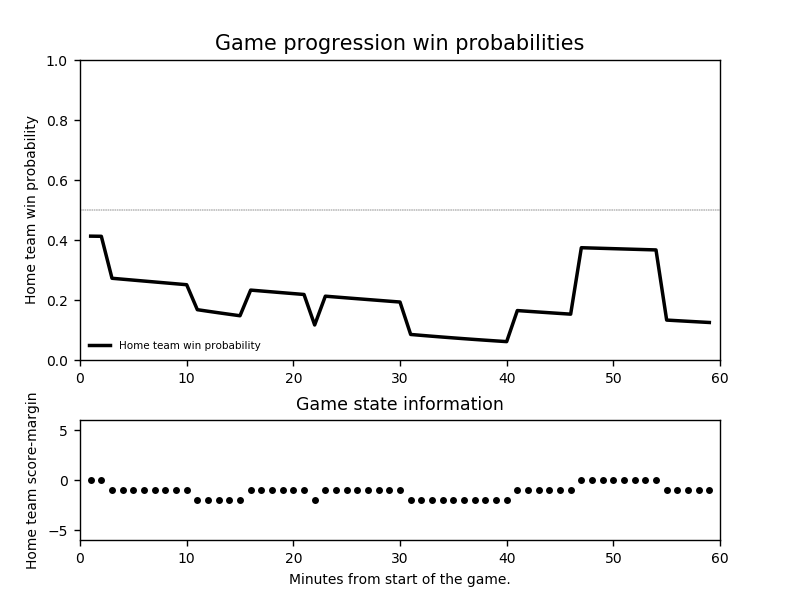

In [120]:
# plot 
plt.rc('axes', grid=False)

width = 0.001
space = width + 0.10
left, width = 0.1, 0.8
rect1 = [left, 0.4, width, 0.5]
rect2 = [left, 0.1, width, 0.2]

fig = plt.figure(facecolor='white')
ax1 = fig.add_axes(rect1, facecolor='white')
ax2 = fig.add_axes(rect2, facecolor='white', sharex=ax1)

ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-6,6])
ax1.set_xlim([0,60])

# ig.suptitle(gameTitle, fontsize=12)
ax1.set_title("Game progression win probabilities", fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Minutes from start of the game.', fontsize=8)

# plot lines
ax1.plot(d1['minStart'], d1['postProb']  , marker='', linestyle='-' , linewidth=2, color='black',  label='Home team win probability')
ax1.axhline(y=.5 ,c="black",linewidth=0.25, linestyle='--', zorder=0)
ax2.plot(d1.minStart, d1.homeSM, '.', linewidth=0.5, color='black')

legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)

# save figure
plt.savefig("gn500.pdf", format='pdf')
# plt.close('all')
plt.show()

## complete

### Done